# Add info to scenarios

In this notebook, we add extra info to the scenarios:

- Total CO$_2$ emissions
- Cumulative net CDR (i.e. sum of emissions in years in which total CO$_2$ emissions are less than zero)
- Year of returning to 1.5
- Cumulative net CDR in year of returning to 1.5

Load in:
- extended emissions file
- extended magicc Temperature/ERF file

Output:
- extended magicc Temperature/ERF file with additional info

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scmdata
import tqdm.autonotebook as tqdman

import utils

<IPython.core.display.Javascript object>

/var/folders/2n/v3g75q4d3636klrs2jxq81zc0000gp/T/ipykernel_66796/3347364542.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [3]:
ID = "zn_fullset"
SCENARIOS_min = [0, 6, 51, 101, 151, 201, 251, 301, 351]
SCENARIOS_max = [5, 50, 100, 150, 200, 250, 300, 350, 400]

<IPython.core.display.Javascript object>

In [4]:
OUTPUT_FILE = (
    utils.DATA_DIR
    / "interim"
    / "magicc-output"
    / f"magicc-output_sb_noSRM_inclu_emission_info.csv"
)
OUTPUT_FILE.parent.parent.mkdir(exist_ok=True)
OUTPUT_FILE.parent.mkdir(exist_ok=True)

<IPython.core.display.Javascript object>

## Total CO$_2$ emissions

In [5]:
# load in as SCM to easily combine fossil and AFOLU
SOURCE_DATA = Path(
    utils.DATA_DIR
    / "interim"
    / "ar6-wg3-extended"
    / f"wg3-timeseries-extended_{ID}.csv"
)

our_set = scmdata.ScmRun(str(SOURCE_DATA)).filter(
    variable=["*CO2*AFOLU*", "*CO2*Energy*"]
)

# Add total CO2
our_set_co2_total = our_set.filter(variable="*CO2*", year=range(2030, 2500+1)).process_over(
    "variable",
    "sum",
    op_cols={"variable": "AR6 climate diagnostics|Infilled|Emissions|CO2"},
    as_run=True,
    min_count=2,
)
our_set_co2_total.to_csv(
    Path(
        utils.DATA_DIR
        / "interim"
        / "ar6-wg3-extended"
        / f"wg3-timeseries-extended_{ID}_CO2_total.csv"
    )
)



<IPython.core.display.Javascript object>

## Cumulative net CDR (counting only negative emissions)

In [21]:
# filter only for plotting
ten_ms = our_set_co2_total.get_unique_meta("ms")[::7][:10]

<IPython.core.display.Javascript object>

/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/plotting.py:96: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(data=plt_df, **kwargs)


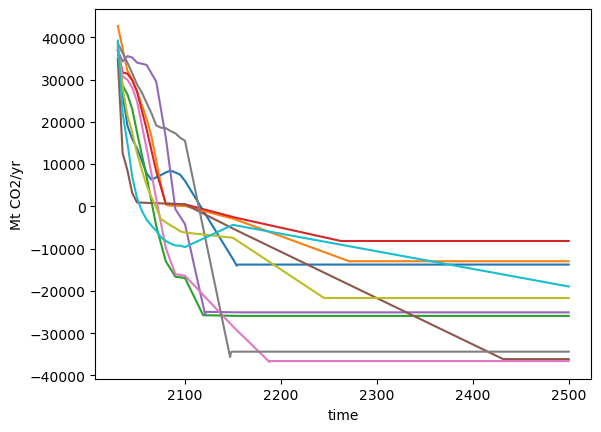

/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/plotting.py:96: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(data=plt_df, **kwargs)


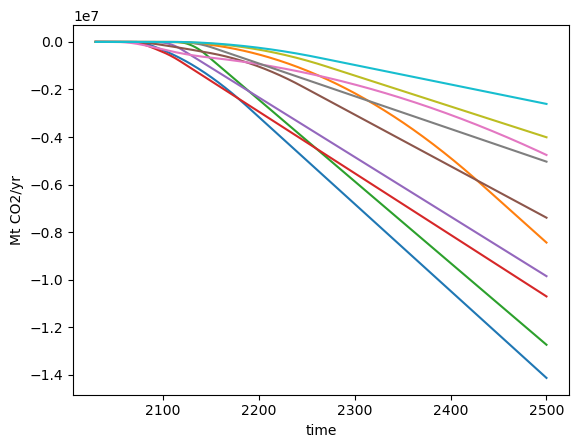

<ScmRun (timeseries: 349, timepoints: 471)>
Time:
	Start: 2030-01-01T00:00:00
	End: 2500-01-01T00:00:00
Meta:
	          max_CDR                  model  \
	0   -39480.833434  MESSAGEix-GLOBIOM_1.1   
	1   -37956.840663  MESSAGEix-GLOBIOM_1.1   
	2   -37587.247564  REMIND-MAgPIE 2.1-4.2   
	3   -37267.859237  MESSAGEix-GLOBIOM_1.1   
	4   -37218.223807           POLES ENGAGE   
	..            ...                    ...   
	344  -1656.976704  MESSAGEix-GLOBIOM_1.1   
	345  -1381.831888           GEM-E3_V2021   
	346  -1171.584087              WITCH 5.0   
	347  -1083.139908           POLES ENGAGE   
	348     23.031643  REMIND-MAgPIE 2.1-4.2   
	
	                                                  ms region  \
	0    MESSAGEix-GLOBIOM_1.1EN_INDCi2030_1600_COV_NDCp  World   
	1       MESSAGEix-GLOBIOM_1.1EN_INDCi2030_3000f_NDCp  World   
	2             REMIND-MAgPIE 2.1-4.2EN_INDCi2030_2500  World   
	3            MESSAGEix-GLOBIOM_1.1EN_INDCi2030_1800f  World   
	4                      POLE

<IPython.core.display.Javascript object>

In [23]:
start = our_set_co2_total.filter(
    variable="AR6 climate diagnostics|Infilled|Emissions|CO2"
)
start.filter(ms=ten_ms).lineplot(legend=False)
plt.show()

# this is where we're losing 7 pathways because they have no negative emissions
total_net_cdr = scmdata.ScmRun(
    start.timeseries(time_axis="year")
    .apply(lambda x: x[x < 0])
    .fillna(0)
    .cumsum(axis=1)
)
total_net_cdr["variable"] = "Cumulative Net CDR|CO2"
total_net_cdr.filter(ms=ten_ms).lineplot(legend=False)
plt.show()

total_net_cdr

## Year of returning to 1.5

### Scenario temperature data

In [24]:
datasets = []

for min_, max_ in tqdman.tqdm(zip(SCENARIOS_min, SCENARIOS_max)):
    DATA_FILE = Path(
        utils.DATA_DIR
        / "interim"
        / "magicc-output"
        / f"magicc-output_{ID}_{min_}_{max_}.csv"
    )
    datasets.append(scmdata.ScmRun(str(DATA_FILE)))

magicc_output = scmdata.run_append(datasets)
magicc_output["ms"] = magicc_output["model"] + magicc_output["scenario"]
magicc_output.head()

0it [00:00, ?it/s]

time                                                                                                                                                                                 1750-01-01 00:00:00  \
climate_model ensemble_member max_CDR       model       ms                                 region run_id scenario                total_CDR     unit  variable                                              
MAGICCv7.5.3  0               -13683.159952 AIM/CGE 2.1 AIM/CGE 2.1CD-LINKS_INDC2030i_1600 World  0      CD-LINKS_INDC2030i_1600 -4.910419e+06 K     Surface Air Temperature Change                  0.0   
                                                                                                                                               W/m^2 Effective Radiative Forcing                     0.0   
              1               -13683.159952 AIM/CGE 2.1 AIM/CGE 2.1CD-LINKS_INDC2030i_1600 World  1      CD-LINKS_INDC2030i_1600 -4.910419e+06 K     Surface Air Temperature Change                  0.0   
                                                                                                                                               W/m^2 Effective Radiative Forcing                     0.0   
              2               -13683.159952 AIM/CGE 2.1 AIM/CGE 2.1CD-LINKS_INDC2030i_1600 World  2      CD-LINKS_INDC2030i_1600 -4.910419e+06 K     Surface Air Temperature Change                  0.0   

time                                                                                                                                                                                 1751-01-01 00:00:00  \
climate_model ensemble_member max_CDR       model       ms                                 region run_id scenario                total_CDR     unit  variable                                              
MAGICCv7.5.3  0               -13683.159952 AIM/CGE 2.1 AIM/CGE 2.1CD-LINKS_INDC2030i_1600 World  0      CD-LINKS_INDC2030i_1600 -4.910419e+06 K     Surface Air Temperature Change             0.021043   
                                                                                                                                               W/m^2 Effective Radiative Forcing                0.100231   
              1               -13683.159952 AIM/CGE 2.1 AIM/CGE 2.1CD-LINKS_INDC2030i_1600 World  1      CD-LINKS_INDC2030i_1600 -4.910419e+06 K     Surface Air Temperature Change             0.025362   
                                                                                                                                               W/m^2 Effective Radiative Forcing                0.157746   
              2               -13683.159952 AIM/CGE 2.1 AIM/CGE 2.1CD-LINKS_INDC2030i_1600 World  2      CD-LINKS_INDC2030i_1600 -4.910419e+06 K     Surface Air Temperature Change             0.024834   

time                                                                                                                                                                                 1752-01-01 00:00:00  \
climate_model ensemble_member max_CDR       model       ms                                 region run_id scenario                total_CDR     unit  variable                                              
MAGICCv7.5.3  0               -13683.159952 AIM/CGE 2.1 AIM/CGE 2.1CD-LINKS_INDC2030i_1600 World  0      CD-LINKS_INDC2030i_1600 -4.910419e+06 K     Surface Air Temperature Change             0.030870   
                                                                                                                                               W/m^2 Effective Radiative Forcing                0.108626   
              1               -13683.159952 AIM/CGE 2.1 AIM/CGE 2.1CD-LINKS_INDC2030i_1600 World  1      CD-LINKS_INDC2030i_1600 -4.910419e+06 K     Surface Air Temperature Change             0.036492   
                                                                                                                          

<IPython.core.display.Javascript object>

In [25]:
temp_ts = (
    magicc_output.filter(variable="Surface Air Temperature Change")
    .filter(year=range(2015, 3000 + 1))
    .timeseries(time_axis="year")
)

<IPython.core.display.Javascript object>

In [27]:
def drop_all_idx_except(iseries, keep_idx):
    return iseries.reset_index(
        list(set(iseries.index.names) - set(keep_idx)),
        drop=True,
    )

<IPython.core.display.Javascript object>

#### Year of coming back down to 1.5°C:
- pathways peaking below 1.5°C i.e. not deploying SRM: 1111
- pathways not coming back down before 2500: 9999

In [28]:
peak_temps = temp_ts.max(axis=1)
peak_temps_lt_15 = peak_temps < 1.5
peak_temps_year = temp_ts.idxmax(axis=1)


year_15 = peak_temps_year * 0

# If peak temperature is less than 1.5,
# 1.5 year is 1111 (not nan to still keep it in the dataset to be able to count the pathways that never deploy SRM)
year_15[peak_temps_lt_15] = 1111

# For runs that peak at greater than 1.5, find if/when they come back down
temp_ts_peak_gt_15 = temp_ts[~peak_temps_lt_15]
for idx, vals in tqdman.tqdm(
    temp_ts_peak_gt_15.iterrows(), total=temp_ts_peak_gt_15.shape[0]
):
    lt_15_after_peak = vals.loc[peak_temps_year[idx] :] <= 1.5  # bool
    if lt_15_after_peak.any():
        year_15[idx] = lt_15_after_peak.idxmax()
    else:
        year_15[idx] = 9999

year_15 = drop_all_idx_except(year_15, ["climate_model", "ensemble_member", "ms"])
year_15.name = "year_return_back_below_15_temp"
year_15.describe()

  0%|          | 0/198409 [00:00<?, ?it/s]

count    208200.000000
mean       3370.212815
std        2846.689013
min        1111.000000
25%        2129.000000
50%        2216.000000
75%        2380.000000
max        9999.000000
Name: year_return_back_below_15_temp, dtype: float64

<IPython.core.display.Javascript object>

## Year of net-zero CO2

In [53]:
## if using < 0 it will set the net-zero date for some pathways really late that have tiny or no CDR
net_zero_df = our_set_co2_total.timeseries().apply(lambda x: x[x < 10]).idxmax(axis=1)

<IPython.core.display.Javascript object>

In [54]:
net_zero_year = drop_all_idx_except(
    net_zero_df, ["climate_model", "ensemble_member", "ms"]
)

<IPython.core.display.Javascript object>

### turn into different format to append to final dataframe

In [58]:
net_zero_year_row = year_15 * 0
net_zero_year_row.name = "net-zero_year"
ms_index = list(year_15.index.names).index("ms")


failed_scenarios = []
for idx, year_15_row in tqdman.tqdm(year_15.items(), total=year_15.shape[0]):
    ms = idx[ms_index]
    try:
        net_zero_year_single = net_zero_year.loc[ms].year
    except KeyError:
        # failes scnearios don't reach net-zero before 2500
        net_zero_year_single = -1111
        failed_scenarios.append(ms)

    net_zero_year_row[idx] = net_zero_year_single
#     break

net_zero_year_row_all = drop_all_idx_except(
    net_zero_year_row, ["climate_model", "ensemble_member", "ms"]
)
len(set(failed_scenarios))

  0%|          | 0/208200 [00:00<?, ?it/s]

6

<IPython.core.display.Javascript object>

In [59]:
net_zero_year_row_all.describe()

count    208200.000000
mean       2054.858790
std         425.164804
min       -1111.000000
25%        2069.000000
50%        2094.000000
75%        2117.000000
max        2466.000000
Name: net-zero_year, dtype: float64

<IPython.core.display.Javascript object>

## Total CDR in year of returning to 1.5

In [60]:
total_net_cdr_ts = total_net_cdr.timeseries(time_axis="year", meta=["ms"])
ms_index = list(year_15.index.names).index("ms")

net_cdr_at_year_15_row = year_15 * 0
net_cdr_at_year_15_row.name = "net_CDR_at_15_temp"

failed_scenarios = []
for idx, year_15_row in tqdman.tqdm(year_15.items(), total=year_15.shape[0]):
    ms = idx[ms_index]
    year_15_row_float = float(year_15_row)

    # Scenario doesn't get back below 1.5C, net CDR at 1.5C is value it has in 2500
    if year_15_row_float == 9999:
        try:
            total_net_cdr_at_15 = total_net_cdr_ts.loc[ms, 2500]
            # exception for pathways that never actually reduce temperatures and therefore never have net-negative
        except:
            #    print(f"exception for {ms}")
            total_net_cdr_at_15 = 0
    # Scenario doesn't overshoot 1.5C, no need for CDR: therefore undefined
    elif year_15_row_float == 1111:
        total_net_cdr_at_15 = np.nan
    else:
        try:
            total_net_cdr_at_15 = total_net_cdr_ts.loc[ms, year_15_row_float]
        except KeyError:
            failed_scenarios.append(ms)
            break

    net_cdr_at_year_15_row[idx] = total_net_cdr_at_15
#     break

net_cdr_at_year_15_row = drop_all_idx_except(
    net_cdr_at_year_15_row, ["climate_model", "ensemble_member", "ms"]
)
len(set(failed_scenarios))

  0%|          | 0/208200 [00:00<?, ?it/s]

0

<IPython.core.display.Javascript object>

## Average CDR between peak and back below 1.5
Use only negative emissions

In [61]:
# average_cdr_at_year_15 = year_15 * 0
# average_cdr_at_year_15.name = "average_cdr_between_peak_and_15_temp"

# peak_temps_year_short_idx = drop_all_idx_except(
#     peak_temps_year, ["climate_model", "ensemble_member", "ms"]
# )

# for idx, year_15_row in tqdman.tqdm(year_15.items(), total=year_15.shape[0]):
#     ms = idx[ms_index]

#     val_year_15_floath = float(year_15_row)
#     if val_year_15_floath == 9999:
#         # Doesn't return below 1.5, calculate average CDR until 2500
#         try:
#             peak_temp_year = net_zero_year.loc[idx]
#             average_cdr = (
#                 total_net_cdr_ts.loc[ms, peak_temp_year]
#                 - total_net_cdr_ts.loc[ms, 2500]
#             ) / (2500 - peak_temp_year)
#             # Exception for pathways that never actually have net-negative emissions
#         except:
#             average_cdr = 0
#     # no SRM, no CDR -> average CDR = 0
#     elif val_year_15_floath == 1111:
#         average_cdr = np.nan

#     else:
#         peak_temp_year = peak_temps_year_short_idx.loc[idx]
#         average_cdr = (
#             total_net_cdr_ts.loc[ms, peak_temp_year]
#             - total_net_cdr_ts.loc[ms, val_year_15_floath]
#         ) / (val_year_15_floath - peak_temp_year)

#     average_cdr_at_year_15[idx] = average_cdr
# #     break

# average_cdr_at_year_15 = drop_all_idx_except(
#     average_cdr_at_year_15, ["climate_model", "ensemble_member", "ms"]
# )

  0%|          | 0/208200 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [66]:
average_cdr_at_year_15.describe()

count    198409.000000
mean       7186.370613
std        6902.132899
min           0.000000
25%         898.243567
50%        5911.843234
75%       10894.014942
max       37041.419341
Name: average_cdr_between_peak_and_15_temp, dtype: float64

<IPython.core.display.Javascript object>

## average annual CDR from net-zero to 1.5°C

we're losing 343 pathways here

In [62]:
average_cdr_net_zero_15 = year_15 * 0
average_cdr_net_zero_15.name = "average_cdr_between_net0_and_15"

peak_temps_year_short_idx = drop_all_idx_except(
    peak_temps_year, ["climate_model", "ensemble_member", "ms"]
)

for idx, year_15_row in tqdman.tqdm(year_15.items(), total=year_15.shape[0]):
    ms = idx[ms_index]

    # if it never reaches net-zero - use 2500
    try:
        year_net0 = net_zero_year.loc[ms].year
    except KeyError:
        year_net0 = 2500

    val_year_15_floath = float(year_15_row)
    if val_year_15_floath == 9999:
        # Doesn't return below 1.5, calculate average CDR until 2500
        try:
            year_net0 = net_zero_year.loc[ms].year
            average_cdr = (
                total_net_cdr_ts.loc[ms, year_net0] - total_net_cdr_ts.loc[ms, 2500]
            ) / (2500 - year_net0)
            # Exception for pathways that never actually have net-negative emissions
        except:
            average_cdr = 0
    # no SRM, no CDR -> average CDR = 0
    elif val_year_15_floath == 1111:
        average_cdr = np.nan

    else:
        average_cdr = (
            total_net_cdr_ts.loc[ms, year_net0]
            - total_net_cdr_ts.loc[ms, val_year_15_floath]
        ) / (val_year_15_floath - year_net0)

    average_cdr_net_zero_15[idx] = average_cdr
#     break

average_cdr_net_zero_15 = drop_all_idx_except(
    average_cdr_net_zero_15, ["climate_model", "ensemble_member", "ms"]
)

  0%|          | 0/208200 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [67]:
average_cdr_net_zero_15.describe()

count    198066.000000
mean       9429.220253
std        6913.863413
min           0.000000
25%        4324.849094
50%        8304.379860
75%       12937.011624
max       35872.165621
Name: average_cdr_between_net0_and_15, dtype: float64

<IPython.core.display.Javascript object>

## Max deployed CDR

Between peak and 1.5C

In [63]:
start_CDR = scmdata.ScmRun(
    start.timeseries(time_axis="year").apply(lambda x: x[x < 0]).fillna(0)
)

<IPython.core.display.Javascript object>

In [64]:
start_CDR_ts = start_CDR.timeseries(time_axis="year", meta=["ms"])

<IPython.core.display.Javascript object>

In [65]:
max_deployed_CDR = year_15 * 0
max_deployed_CDR.name = "max_deployed_CDR"

peak_temps_year_short_idx = drop_all_idx_except(
    peak_temps_year, ["climate_model", "ensemble_member", "ms"]
)

for idx, year_15_row in tqdman.tqdm(year_15.items(), total=year_15.shape[0]):
    ms = idx[ms_index]

    val_year_15_floath = float(year_15_row)
    if val_year_15_floath == 9999:
        # Doesn't return below 1.5, use CDR in 2500
        try:
            peak_temp_year = peak_temps_year_short_idx.loc[idx]
            max_CDR = start_CDR_ts.loc[ms, 2500]

            # Exception for pathways that never actually have net-negative emissions
        except:
            max_CDR = 0
    # no SRM, no CDR -> average CDR = 0
    elif val_year_15_floath == 1111:
        max_CDR = np.nan
    # use CDR in the 1.5°C year as indicator for max deployed CDR
    else:
        peak_temp_year = peak_temps_year_short_idx.loc[idx]
        max_CDR = start_CDR_ts.loc[ms, val_year_15_floath]

    max_deployed_CDR[idx] = max_CDR
#     break

max_deployed_CDR = drop_all_idx_except(
    max_deployed_CDR, ["climate_model", "ensemble_member", "ms"]
)

  0%|          | 0/208200 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

### Average annual emissions between 2030 and net-zero

In [68]:
### calculate average emissions between 2030 and net-zero (divide 2030 levels by 2)
avg_annual_2030 = our_set_co2_total.timeseries(time_axis="year", meta=["ms"])[2030] / 2

<IPython.core.display.Javascript object>

In [69]:
avg_annual_em_2030_net0 = year_15 * 0
avg_annual_em_2030_net0.name = "average_annual_emissions_2030_net-zero"


failed_scenarios = []
for idx, year_15_row in tqdman.tqdm(year_15.items(), total=year_15.shape[0]):
    ms = idx[ms_index]
    try:
        avg_annual_2030_single = avg_annual_2030.loc[ms]
    except KeyError:
        avg_annual_2030_single = 0
        failed_scenarios.append(ms)

    avg_annual_em_2030_net0[idx] = avg_annual_2030_single
#     break

avg_annual_em_2030_net0_all = drop_all_idx_except(
    avg_annual_em_2030_net0, ["climate_model", "ensemble_member", "ms"]
)
len(set(failed_scenarios))

  0%|          | 0/208200 [00:00<?, ?it/s]

0

<IPython.core.display.Javascript object>

## Other metrics

- cumulative emissions to peak
- cumulative emissions at 1.5C
- cumulative emissions from peak-warming to 1.5C
- cumulative positive emissions at 1.5C

In [70]:
# setup
cumulative_emms_peak_warming = year_15 * 0
cumulative_emms_peak_warming.name = "cumulative_emms_peak_warming"

cumulative_emms_at_15 = year_15 * 0
cumulative_emms_at_15.name = "cumulative_emms_15"

cumulative_emms_peak_warming_to_15 = year_15 * 0
cumulative_emms_peak_warming_to_15.name = "cumulative_emms_peak_warming_to_15"

cumulative_pos_emms_at_15 = year_15 * 0
cumulative_pos_emms_at_15.name = "cumulative_pos_emms_at_15"

cumulative_pos_emms_at_net0 = year_15 * 0
cumulative_pos_emms_at_net0.name = "cumulative_pos_emms_at_net0"

cumulative_emms_net0_em_to_15 = year_15 * 0
cumulative_emms_net0_em_to_15.name = "cumulative_emms_net0_to_15"

# calculate timeseries we need
our_set_co2_total_cumulative_emms_ts = our_set_co2_total.cumsum().timeseries(
    time_axis="year", meta=["ms"]
)
our_set_co2_total_pos_cumulative_emms_ts = (
    our_set_co2_total.timeseries(time_axis="year", meta=["ms"])
    .apply(lambda x: x[x > 0])
    .fillna(0)
    .cumsum(axis=1)
)


ms_index = list(year_15.index.names).index("ms")
for idx, year_15_row in tqdman.tqdm(year_15.items(), total=year_15.shape[0]):
    if year_15_row == 9999:
        # nan throws error so let's just assign 2500 - it doesn't really matter since we'll kick the
        # 9999 and 1111 pathways out before doing the plots etc anyway
        year_15_row = 2500  # np.nan
        try:
            peak_temp_year = peak_temps_year_short_idx.loc[idx]
            # if it never peaks - use 2500 as peak
        except:
            peak_temp_year = 2500
    if year_15_row == 1111:
        #         peak_temp_year = np.nan
        #         year_15_row = np.nan
        continue

    ms = idx[ms_index]

    peak_temp_year = peak_temps_year_short_idx.loc[idx]
    # if it never reaches net-zero - use 2500
    try:
        year_net0 = net_zero_year.loc[ms].year
    except KeyError:
        year_net0 = 2500

    cumulative_emms_peak = our_set_co2_total_cumulative_emms_ts.loc[ms, peak_temp_year]
    cumulative_emms_15 = our_set_co2_total_cumulative_emms_ts.loc[ms, year_15_row]
    cumulative_emms_net0 = our_set_co2_total_cumulative_emms_ts.loc[ms, year_net0]
    cumulative_pos_emms_net0 = our_set_co2_total_pos_cumulative_emms_ts.loc[
        ms, year_net0
    ]

    cumulative_emms_peak_to_15 = cumulative_emms_15 - cumulative_emms_peak
    cumulative_emms_net0_to_15 = cumulative_emms_15 - cumulative_emms_net0
    cumulative_pos_emms_15 = our_set_co2_total_pos_cumulative_emms_ts.loc[
        ms, year_15_row
    ]

    cumulative_emms_peak_warming[idx] = cumulative_emms_peak
    cumulative_emms_at_15[idx] = cumulative_emms_15
    cumulative_emms_peak_warming_to_15[idx] = cumulative_emms_peak_to_15
    cumulative_emms_net0_em_to_15[idx] = cumulative_emms_net0_to_15
    cumulative_pos_emms_at_15[idx] = cumulative_pos_emms_15
    cumulative_pos_emms_at_net0[idx] = cumulative_pos_emms_net0

#     break

cumulative_emms_peak_warming = drop_all_idx_except(
    cumulative_emms_peak_warming, ["climate_model", "ensemble_member", "ms"]
)

cumulative_emms_at_15 = drop_all_idx_except(
    cumulative_emms_at_15, ["climate_model", "ensemble_member", "ms"]
)

cumulative_emms_peak_warming_to_15 = drop_all_idx_except(
    cumulative_emms_peak_warming_to_15, ["climate_model", "ensemble_member", "ms"]
)
cumulative_emms_net0_em_to_15 = drop_all_idx_except(
    cumulative_emms_net0_em_to_15, ["climate_model", "ensemble_member", "ms"]
)
cumulative_pos_emms_at_15 = drop_all_idx_except(
    cumulative_pos_emms_at_15, ["climate_model", "ensemble_member", "ms"]
)
cumulative_pos_emms_at_net0 = drop_all_idx_except(
    cumulative_pos_emms_at_net0, ["climate_model", "ensemble_member", "ms"]
)
cumulative_pos_emms_at_15.head()

  0%|          | 0/208200 [00:00<?, ?it/s]

climate_model  ensemble_member  ms                                
MAGICCv7.5.3   0                AIM/CGE 2.1CD-LINKS_INDC2030i_1600    909213.148461
               1                AIM/CGE 2.1CD-LINKS_INDC2030i_1600    909213.148461
               2                AIM/CGE 2.1CD-LINKS_INDC2030i_1600    909213.148461
               3                AIM/CGE 2.1CD-LINKS_INDC2030i_1600    909213.148461
               4                AIM/CGE 2.1CD-LINKS_INDC2030i_1600    909213.148461
Name: cumulative_pos_emms_at_15, dtype: float64

<IPython.core.display.Javascript object>

In [71]:
cumulative_emms_net0_em_to_15.describe()

count    2.082000e+05
mean    -1.562694e+06
std      2.034248e+06
min     -1.446433e+07
25%     -1.941047e+06
50%     -8.320053e+05
75%     -2.601045e+05
max      3.757211e+05
Name: cumulative_emms_net0_to_15, dtype: float64

<IPython.core.display.Javascript object>

In [76]:
cumulative_emms_peak_warming_to_15.describe()

count    2.082000e+05
mean    -1.440462e+06
std      1.971691e+06
min     -1.432748e+07
25%     -1.842739e+06
50%     -7.819296e+05
75%     -1.763352e+05
max      1.855471e+06
Name: cumulative_emms_peak_warming_to_15, dtype: float64

<IPython.core.display.Javascript object>

## Put it all back together

In [73]:
magicc_output["max_assigned_CDR"] = magicc_output["max_CDR"]
magicc_output = magicc_output.drop_meta("max_CDR")

<IPython.core.display.Javascript object>

In [74]:
magicc_output_ts = magicc_output.timeseries(time_axis="year")
magicc_output_ts = (
    magicc_output_ts.join(net_cdr_at_year_15_row)
    .join(year_15)
    .join(net_zero_year_row_all)
    .join(avg_annual_em_2030_net0_all)
    #   .join(average_cdr_at_year_15)
    .join(average_cdr_net_zero_15)
    .join(max_deployed_CDR)
    .join(cumulative_emms_peak_warming)
    .join(cumulative_emms_at_15)
    .join(cumulative_emms_peak_warming_to_15)
    .join(cumulative_emms_net0_em_to_15)
    .join(cumulative_pos_emms_at_15)
    .join(cumulative_pos_emms_at_net0)
)
magicc_output_ts.head()

1750  \
climate_model ensemble_member ms                                 max_assigned_CDR model       region run_id scenario                total_CDR     unit  variable                               
MAGICCv7.5.3  0               AIM/CGE 2.1CD-LINKS_INDC2030i_1600 -13683.159952    AIM/CGE 2.1 World  0      CD-LINKS_INDC2030i_1600 -4.910419e+06 K     Surface Air Temperature Change   0.0   
                                                                                                                                                  W/m^2 Effective Radiative Forcing      0.0   
                              AIM/CGE 2.1CD-LINKS_NDC2030i_1000  -8395.374329     AIM/CGE 2.1 World  600    CD-LINKS_NDC2030i_1000  -3.531033e+06 K     Surface Air Temperature Change   0.0   
                                                                                                                                                  W/m^2 Effective Radiative Forcing      0.0   
                              AIM/CGE 2.2EN_INDCi2030_1000f      -10788.933173    AIM/CGE 2.2 World  1200   EN_INDCi2030_1000f      -4.445832e+06 K     Surface Air Temperature Change   0.0   

                                                                                                                                                                                            1751  \
climate_model ensemble_member ms                                 max_assigned_CDR model       region run_id scenario                total_CDR     unit  variable                                   
MAGICCv7.5.3  0               AIM/CGE 2.1CD-LINKS_INDC2030i_1600 -13683.159952    AIM/CGE 2.1 World  0      CD-LINKS_INDC2030i_1600 -4.910419e+06 K     Surface Air Temperature Change  0.021043   
                                                                                                                                                  W/m^2 Effective Radiative Forcing     0.100231   
                              AIM/CGE 2.1CD-LINKS_NDC2030i_1000  -8395.374329     AIM/CGE 2.1 World  600    CD-LINKS_NDC2030i_1000  -3.531033e+06 K     Surface Air Temperature Change  0.021043   
                                                                                                                                                  W/m^2 Effective Radiative Forcing     0.100231   
                              AIM/CGE 2.2EN_INDCi2030_1000f      -10788.933173    AIM/CGE 2.2 World  1200   EN_INDCi2030_1000f      -4.445832e+06 K     Surface Air Temperature Change  0.021043   

                                                                                                                                                                                            1752  \
climate_model ensemble_member ms                                 max_assigned_CDR model       region run_id scenario                total_CDR     unit  variable                                   
MAGICCv7.5.3  0               AIM/CGE 2.1CD-LINKS_INDC2030i_1600 -13683.159952    AIM/CGE 2.1 World  0      CD-LINKS_INDC2030i_1600 -4.910419e+06 K     Surface Air Temperature Change  0.030870   
                                                                                                                                                  W/m^2 Effective Radiative Forcing     0.108626   
                              AIM/CGE 2.1CD-LINKS_NDC2030i_1000  -8395.374329     AIM/CGE 2.1 World  600    CD-LINKS_NDC2030i_1000  -3.531033e+06 K     Surface Air Temperature Change  0.030870   
                                                                                                                                                  W/m^2 Effective Radiative Forcing     0.108626   
                              AIM/CGE 2.2EN_INDCi2030_1000f      -10788.933173    AIM/CGE 2.2 World  1200   EN_INDCi2030_1000f      -4.445832e+06 K     Surface Air Temperature Change  0.030870   

                                                                                             

<IPython.core.display.Javascript object>

In [77]:
magicc_output_ts.shape

(416400, 774)

<IPython.core.display.Javascript object>

In [75]:
scmdata.ScmRun(magicc_output_ts).to_csv(OUTPUT_FILE)

<IPython.core.display.Javascript object>